<img src="escuela-de-economia.png" width="260" height="60">
<center>
    <b>EC4301 MACROECONOMETRÍA</b><br>
    <b>Profesor:  Randall Romero Aguilar, PhD</b>
<br><br>
<b>Laboratorio:</b>
<div style="font-size:175%;color:white; background-color: #0064b0;">Tema 5: Modelos para series con tendencia</div>
<div style="font-size:250%;color:white; background-color: #0064b0;">Series estacionarias en diferencia vs estacionarias alrededor de una tendencia</div> 
</center>
<i>Creado:     2020-May-01 
    <br>
    Actualizado: 2020-Oct-25</i>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
import seaborn as sns

In [3]:
from scipy.stats import t as t_Student

In [4]:
plt.style.use('seaborn')
plt.rc('figure', figsize=(15,4))
plt.rc('axes', titlesize=20, labelsize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)

# Estacionario en diferencia vs estacionario en tendencia

Ejemplo basado en Levendis 2019, pp. 109-113. Muestra que no es tan fácil distinguir a simple vista un proceso estacionario en diferencia de uno estacionario alrededor de una tendencia.

In [5]:
T = 100
np.random.seed(12345)
tt = np.arange(T)
e = np.random.randn(T)

In [6]:
datos = pd.DataFrame({'t':tt, 'e':e}, index=tt)
datos['DS'] = (1+e).cumsum()
datos['TS'] = 1*tt + e
datos


,t,e,DS,TS
0,0,-0.204708,0.795292,-0.204708
1,1,0.478943,2.274236,1.478943
2,2,-0.519439,2.754797,1.480561
3,3,-0.555730,3.199067,2.444270
4,4,1.965781,6.164847,5.965781
...,...,...,...,...
95,95,0.795253,99.254214,95.795253
96,96,0.118110,100.372324,96.118110
97,97,-0.748532,100.623793,96.251468
98,98,0.584970,102.208762,98.584970


In [7]:
%%timeit
lento = pd.DataFrame({'t':tt, 'e':e}, index=tt)

# caminata aleatoria
y = np.zeros(T)
y[0] = 1 + e[0]
for t in range(1, T):
    y[t] = 1 + y[t-1] + e[t]

# estacionario alrededor de tendencia    
x = np.zeros(T)
x[0] = e[0]
for t in range(1, T):
    x[t] = 1 * tt[t] + e[t]

lento['y'] = y
lento['x'] = x
#lento

1.64 ms ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [8]:
detrended = pd.DataFrame(
    {'DS':smf.ols('DS ~ t', datos).fit().resid,
     'TS':smf.ols('TS ~ t', datos).fit().resid
    }, index=tt)

In [9]:
def ols_ala_stata(formula):
    return smf.ols(formula, datos).fit().summary()

In [10]:
ols_ala_stata('DS ~ t + TS -1')

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     DS   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              7233.
Date:                Sun, 25 Oct 2020   Prob (F-statistic):                   3.71e-107
Time:                        20:51:17   Log-Likelihood:                         -297.34
No. Observations:                 100   AIC:                                      598.7
Df Residuals:                      98   BIC:                                      603.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
t              0.4261      0.463      0.921      0.359      -0.492       1.344
TS             0.5768      0.462      1.248      0.215      -0.340       1.494
==============================================================================
Omnibus:                       17.306   Durbin-Watson:                   0.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.610
Skew:                           0.374   Prob(JB):                       0.0367
Kurtosis:                       1.986   Cond. No.                         111.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

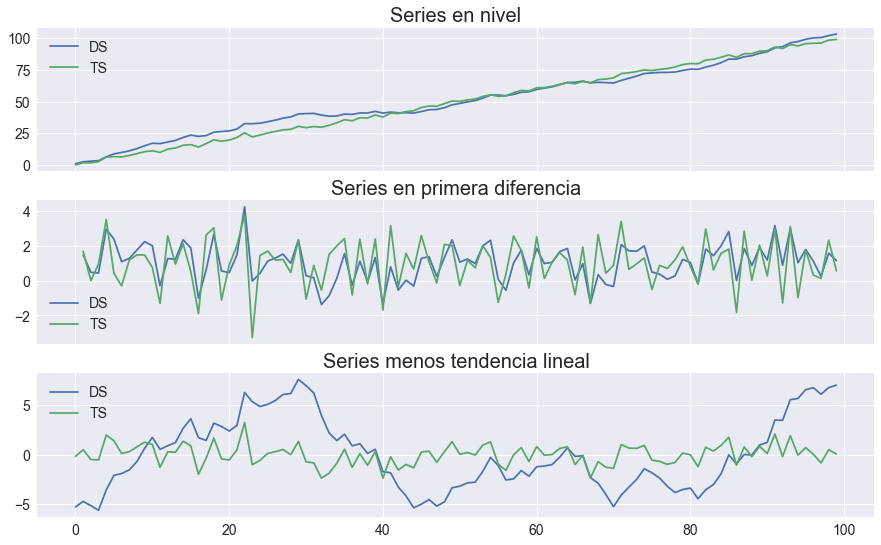

In [11]:
fig, axs = plt.subplots(3,1, figsize=[15,9], sharex=True)
series = ['DS', 'TS']
datos[series].plot(ax=axs[0], title='Series en nivel')
datos[series].diff().plot(ax=axs[1], title='Series en primera diferencia')
detrended[series].plot(ax=axs[2], title='Series menos tendencia lineal')


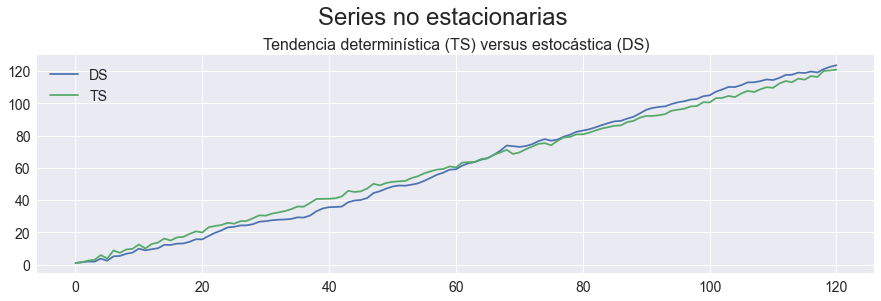

In [12]:
np.random.seed(1)
T = 121
e = np.random.randn(T)
e[0] = 0

x0 = y0 = a = 1
t = np.arange(T)

y = y0 + a*t + e.cumsum()
x = x0 + a*t + e

ejemplo = pd.DataFrame({'DS':y,'TS':x})    

fig, ax = plt.subplots()
ejemplo.plot(ax=ax)
ax.set_title('Tendencia determinística (TS) versus estocástica (DS)', fontsize=16)
fig.suptitle('Series no estacionarias',fontsize=24, y=1.05)
fig.savefig('TS-DS-sample.pdf', bbox_inches='tight')

Repetimos el ejercicio, pero con un millón de observaciones

In [13]:
T = 1_000_000
np.random.seed(12345)
tt = np.arange(T)
e = np.random.randn(T)

#%%timeit
big = pd.DataFrame({'t':tt, 'e':e}, index=tt)
big['DS'] = (1+e).cumsum()
big['TS'] = tt + e

bigdetrended = pd.DataFrame(
    {'DS':smf.ols('DS~t', big).fit().resid,
     'TS':smf.ols('TS~t', big).fit().resid
    }, index=tt)

resumen = pd.concat([
    big[series].diff().describe().T,
    bigdetrended[series].describe().T
], keys=['1-diff', '- tend'])

resumen

count          mean         std         min         25%  \
1-diff DS   999999.0  1.001494e+00    0.999954   -4.057590    0.326730   
       TS   999999.0  1.000001e+00    1.414065   -5.800262    0.046267   
- tend DS  1000000.0 -3.559165e-09  158.846292 -405.803718 -118.686166   
       TS  1000000.0  6.236537e-10    0.999953   -5.058701   -0.674670   

                 50%         75%         max  
1-diff DS   1.001364    1.674426    5.979780  
       TS   1.000069    1.951536    7.517358  
- tend DS -15.663626  136.408845  372.938439  
       TS  -0.000123    0.672972    4.978591

# Autocorrelación de una caminata aleatoria

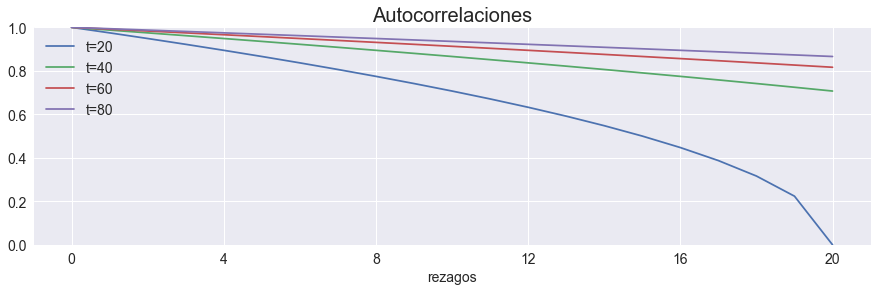

In [14]:
def rw_rho(t, smax=20):
    """
    Calcula las primera autocorrelaciones de una serie con raiz unitaria
    
    Ver página 56 de los apuntes del tema 4 del curso
    """
    return np.sqrt(1 - np.arange(smax+1) /t)

rw_rho_data = pd.DataFrame({f't={t}':rw_rho(t) for t in [20,40,60,80]})
     
fig, ax = plt.subplots()
rw_rho_data.plot(ax=ax)
ax.set(ylim=[0,1], xticks=np.arange(0,21,4), xlabel='rezagos', title='Autocorrelaciones')
plt.savefig('rw-rho.pdf', bbox_inches='tight')